In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import trange
import glob,os
from tensorflow.python.client import device_lib
import tensorflow_datasets as tfds

In [2]:
data_dir = '/home/Downloads/training_data'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                    data_dir,
                    label_mode = None,
                    batch_size = 1,
                    image_size = (128,128))
train_ds = train_ds.unbatch()
N_IMAGES = 15000
train_ds = train_ds.take(N_IMAGES)
BUFFER_SIZE = N_IMAGES
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_ds = train_ds.map(lambda x: (x-127.5)/127.5)

Found 15000 files belonging to 1 classes.


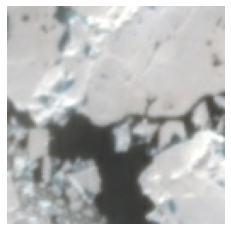

In [3]:
for item in train_ds.take(1):
    plt.imshow(item[0,...]*0.5+0.5)
    plt.axis('off')
    plt.pause(0.5)

In [5]:
class ResnetUpSampleBlock(tf.keras.layers.Layer):
    def __init__(self, filter_size):
        super(ResnetUpSampleBlock, self).__init__(name='')
        
        self.bn2a = tf.keras.layers.BatchNormalization()

        self.conv2a = tf.keras.layers.Conv2DTranspose(filter_size, 
                                                      kernel_size=(3, 3), strides=(2,2), 
                                                      padding='same',use_bias=False)
        
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.conv2b = tf.keras.layers.Conv2DTranspose(filter_size, 
                                                      kernel_size=(3,3), strides=(1,1), 
                                                      padding='same',use_bias=False)
        
        
        self.convReshape = tf.keras.layers.Conv2DTranspose(filter_size,
                                                           kernel_size=(3,3),strides=(2,2),
                                                           padding='same',use_bias=False)

    def call(self, input_tensor, training=False):
        x = self.bn2a(input_tensor, training=training)
        x = tf.nn.relu(x)
        x = self.conv2a(x)
        x = self.bn2b(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2b(x)
    
        input_tensor_reshaped = self.convReshape(input_tensor)
        x += input_tensor_reshaped
        return x
    
class ResnetDownSampleBlock(tf.keras.layers.Layer):
    def __init__(self,filter_size):
        super(ResnetDownSampleBlock, self).__init__(name='')

        self.bn2a = tf.keras.layers.BatchNormalization()
        self.conv2a = tf.keras.layers.Conv2D(filter_size, 
                                             kernel_size=(3, 3), strides=(1,1),
                                             padding='same',use_bias=False)
        
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conv2b = tf.keras.layers.Conv2D(filter_size, 
                                             kernel_size=(3,3), strides=(2,2), 
                                             padding='same',use_bias=False)
        
        self.convReshape = tf.keras.layers.Conv2D(filter_size,
                                                  kernel_size=(3,3),strides=(2,2),
                                                  padding='same',use_bias=False)

    def call(self, input_tensor, training=False):
        x = self.bn2a(input_tensor, training=training)
        x = tf.nn.relu(x)
        x = self.conv2a(x)
        
        x = self.bn2b(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2b(x)
        
        input_tensor_reshaped = self.convReshape(input_tensor)
        x += input_tensor_reshaped
        return x

In [6]:
def make_generator(latent_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((4, 4, 512)))
    assert model.output_shape == (None, 4, 4, 512)
    model.add(ResnetUpSampleBlock(512))
    assert model.output_shape == (None,8,8,512)
    model.add(ResnetUpSampleBlock(256))
    assert model.output_shape == (None,16,16,256)
    model.add(ResnetUpSampleBlock(256))
    assert model.output_shape == (None,32,32,256)
    model.add(ResnetUpSampleBlock(128))
    assert model.output_shape == (None,64,64,128)
    model.add(ResnetUpSampleBlock(64))
    assert model.output_shape == (None,128,128,64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2D(3, (3, 3), strides=(1, 1), padding='same', 
                            use_bias=False,activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model


def make_discriminator():
    model = tf.keras.Sequential()
    model.add(ResnetDownSampleBlock(64))
    model.add(ResnetDownSampleBlock(128))
    model.add(ResnetDownSampleBlock(256))
    model.add(ResnetDownSampleBlock(256))
    model.add(ResnetDownSampleBlock(512))
    model.add(ResnetDownSampleBlock(512))
    model.add(layers.Flatten())
    model.add(layers.ReLU())
    model.add(layers.Dense(512))
    model.add(layers.Dense(1))

    return model

In [7]:
latent_dim = 128
generator = make_generator(latent_dim)
discriminator = make_discriminator()

In [8]:
# deleting images in image_dir
image_dir = 'images/resnet_gan/'
for f in glob.glob(dir_name+'*.png'):
    os.remove(f)

def save_generator_samples(epoch):
    z = tf.random.normal([9,latent_dim])
    images = generator(z,training=False)
    fig = plt.figure(figsize=(6,6))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i]*0.5+0.5)
        plt.axis('off')
    plt.suptitle('epoch: %03d'%(epoch))
    plt.savefig(image_dir+'image_at_epoch_{:04d}.png'.format(epoch))
    plt.close(fig)

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_loss(fake_output):
    g_loss = cross_entropy(tf.ones_like(fake_output),fake_output)
    return g_loss

def discriminator_loss(fake_output,real_output,smoothing_factor=0.9):
    d_loss_real = cross_entropy(tf.ones_like(real_output)*smoothing_factor,real_output)
    d_loss_fake = cross_entropy(tf.zeros_like(fake_output),fake_output)
    d_loss = d_loss_real+d_loss_fake
    return d_loss
    
LR_g = 1e-5
LR_d = 1e-5
BETA_1 = 0.9
generator_opt = tf.keras.optimizers.Adam(learning_rate=LR_g,beta_1=BETA_1)
discriminator_opt = tf.keras.optimizers.Adam(learning_rate=LR_d,beta_1=BETA_1)

@tf.function
def train_step(real_images):
    z = tf.random.normal([BATCH_SIZE,latent_dim])
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        generated_images = generator(z,training=True)
        fake_output = discriminator(generated_images,training=True)
        real_output = discriminator(real_images,training=True)
        
        g_loss = generator_loss(fake_output)
        d_loss = discriminator_loss(fake_output,real_output)
        
    g_grad = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grad = d_tape.gradient(d_loss, discriminator.trainable_variables)
    
    generator_opt.apply_gradients(zip(g_grad,generator.trainable_variables))
    discriminator_opt.apply_gradients(zip(d_grad,discriminator.trainable_variables))
    
    return d_loss,g_loss

def train(dataset, epochs):
    t = trange(epochs)
    for epoch in t:
        for data_batch in dataset:
            d_loss,g_loss = train_step(data_batch)
            t.set_description("D loss: %0.5f G loss: %0.5f" %(d_loss.numpy(),g_loss.numpy()))
            t.refresh()
        save_generator_samples(epoch+98)
EPOCHS = 100
train(train_ds,EPOCHS)

D loss: 0.34592 G loss: 14.64938: 100%|██████████| 100/100 [1:48:04<00:00, 64.84s/it]


In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              1048576   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
resnet_up_sample_block (Resn (None, 8, 8, 512)         7081984   
_________________________________________________________________
resnet_up_sample_block_1 (Re (None, 16, 16, 256)       2952192   
_________________________________________________________________
resnet_up_sample_block_2 (Re (None, 32, 32, 256)       1771520   
_________________________________________________________________
resnet_up_sample_block_3 (Re (None, 64, 64, 128)       738816    
_________________________________________________________________
resnet_up_sample_block_4 (Re (None, 128, 128, 64)      1

In [28]:
def plot_samples(model,size):
    z = tf.random.normal([size**2,latent_dim])
    images = model(z,training=False)
    fig = plt.figure(figsize=(7,7))
    for i in range(size**2):
        plt.subplot(size,size,i+1)
        plt.imshow(images[i]*0.5+0.5)
        plt.axis('off')
    plt.pause(0.05)

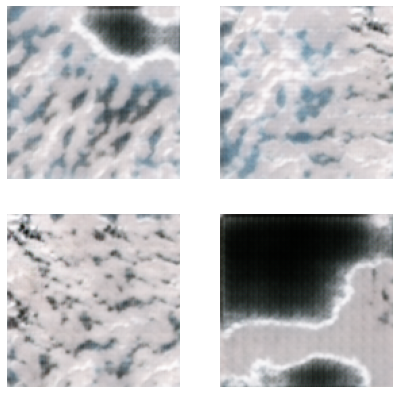

In [15]:
plot_samples(generator,2)

In [16]:
#saving model
generator.compile(generator_opt)
generator.save('/home/repos/crrel/sea_ice_models/resnet_gan/generator')

discriminator.compile(discriminator_opt)
discriminator.save('/home/repos/crrel/sea_ice_models/resnet_gan/discriminator')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/resnet_gan_seaice/generator/assets
INFO:tensorflow:Assets written to: models/resnet_gan_seaice/disciminator/assets
